# VASP with pyiron: Bandstructure of Si using hybrid functionals


This notebook aims to reproduce the VASP manual [tutorial](https://www.vasp.at/wiki/index.php/Si_bandstructure) of the calculation of the band structure of Si using GGA and the HSE06 potentials

In [1]:
from pyiron_atomistics import Project
import matplotlib.pyplot as plt
import seekpath as sp
import numpy as np

In [2]:
pr = Project("Si_bandstructure")

In [3]:
structure_Si = pr.create_ase_bulk("Si", a=5.43)

In [4]:
structure_Si

Si: [0. 0. 0.]
Si: [1.3575 1.3575 1.3575]
pbc: [ True  True  True]
cell: 
Cell([[0.0, 2.715, 2.715], [2.715, 0.0, 2.715], [2.715, 2.715, 0.0]])

In [5]:
input_sp = (structure_Si.cell, structure_Si.get_scaled_positions(), structure_Si.indices)

In [6]:
structure_Si_sp = structure_Si.create_line_mode_structure()

In [7]:
structure_Si_sp.get_high_symmetry_path()

{'full': [('GAMMA', 'X'),
  ('X', 'U'),
  ('K', 'GAMMA'),
  ('GAMMA', 'L'),
  ('L', 'W'),
  ('W', 'X')]}

## Bandstructure GGA

In [8]:
def setup_hamiltonian_vasp(project, jobname, structure, chgcar_file=""): 

    ham = project.create_job(job_type='Vasp', job_name=jobname)
    ham.exchange_correlation_functional = 'PBE'
    ham.structure = structure

    ham.set_encut(450)
    ham.set_empty_states(6)
    ham.set_convergence_precision(electronic_energy=1e-8)
    ham.set_occupancy_smearing("gaussian", width=0.01)
          
    #parameter für kpoints
    ham.set_kpoints([4, 4, 4])    
    # Write the wave functions
    ham.write_wave_funct = True
    return ham

In [9]:
job_scf = setup_hamiltonian_vasp(pr, "Si_scf", structure_Si_sp)

In [10]:
job_scf.run()

2022-02-25 09:56:28,383 - pyiron_log - WARNING - The job Si_scf is being loaded instead of running. To re-run use the argument 'delete_existing_job=True in create_job'


In [11]:
job_bs = job_scf.restart_for_band_structure_calculations(job_name="Si_BS")

In [12]:
n_path = 50 # Number of points between each special k-point

job_bs.set_kpoints(scheme="Line", path_name="full", n_path=n_path)

In [13]:
job_bs.run()

2022-02-25 09:56:28,964 - pyiron_log - WARNING - The job Si_BS is being loaded instead of running. To re-run use the argument 'delete_existing_job=True in create_job'


## Bandstructure HSE06

In [14]:
k_weights_scf = job_scf["output/electronic_structure/k_weights"]
k_points_scf = job_scf["output/electronic_structure/k_points"]
k_points_bs = job_bs["output/electronic_structure/k_points"]

In [15]:
input_kpoints = np.append(k_points_scf, k_points_bs, axis=0)
input_kweights = np.append(k_weights_scf, np.zeros(len(k_points_bs)))


In [16]:
job_bs_hse = job_scf.restart_from_wave_functions(job_name="Si_BS_HSE")

In [17]:
job_bs_hse.set_kpoints(scheme="Manual", manual_kpoints=input_kpoints, weights=input_kweights)

In [18]:
# HSE06 parameters

job_bs_hse.input.incar["LHFCALC"] = True
job_bs_hse.input.incar["HFSCREEN"] = 0.2
job_bs_hse.input.incar["AEXX"] = 0.25
job_bs_hse.input.incar["ALGO"] = "D" 
job_bs_hse.input.incar["TIME"] = 0.4
job_bs_hse.input.incar["LDIAG"] = True

In [19]:
job_bs_hse.server.cores = 40
job_bs_hse.server.queue = "cm"

In [20]:
job_bs_hse.run()

2022-02-25 09:56:29,622 - pyiron_log - WARNING - The job Si_BS_HSE is being loaded instead of running. To re-run use the argument 'delete_existing_job=True in create_job'


In [21]:
job_bs_hse.status

'finished'

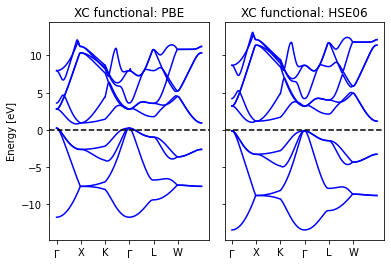

In [22]:

if job_bs_hse.status.finished:
    fig, ax_list = plt.subplots(ncols=2, nrows=1, sharey=True)

    fermi_level = job_scf['output/electronic_structure/efermi']
    eig_gga = job_bs['output/electronic_structure/eig_matrix'] - fermi_level
    eig_hse06 = job_bs_hse['output/electronic_structure/eig_matrix'] - fermi_level

    # Only include the kpoints and bands we want
    eig_hse06 = eig_hse06[:, len(k_points_scf):, :eig_gga.shape[2]]

    path = [val[0] if val[0] != "GAMMA" else "$\mathrm{\Gamma}$" for val in job_bs.structure.get_high_symmetry_path()["full"] ]

    labels = {"PBE": eig_gga, "HSE06": eig_hse06}

    for i, (xc, eig) in enumerate(labels.items()):
        ax = ax_list[i]
        ax.plot(eig[0], 'b-')
        ax.axhline(y=0, ls='--', c='k')

        ax.set_title(f"XC functional: {xc}")

        ax.set_xticks([n * 50 for n in range(len(path))])
        ax.set_xticklabels(path)

    ax_list[0].set_ylabel("Energy [eV]")
    fig.subplots_adjust(wspace=0.1);

In [23]:
pr.job_table()

,id,status,chemicalformula,job,subjob,projectpath,project,timestart,timestop,totalcputime,computer,hamilton,hamversion,parentid,masterid
2,16683765,finished,Si2,Si_scf,/Si_scf,/cmmc/u/,chandu/projects_2022/development/Si_bandstructure/,2022-02-24 19:19:15.678678,2022-02-24 19:19:19.700419,4.0,chandu@cmti001#1,Vasp,5.4.4,NaN,None
0,16683766,finished,Si2,Si_BS,/Si_BS,/cmmc/u/,chandu/projects_2022/development/Si_bandstructure/,2022-02-24 19:19:21.460375,2022-02-24 19:19:52.284120,30.0,chandu@cmti001#1,Vasp,5.4.4,16683765.0,None
1,16683768,finished,Si2,Si_BS_HSE,/Si_BS_HSE,/cmmc/u/,chandu/projects_2022/development/Si_bandstructure/,2022-02-24 19:27:36.409046,2022-02-25 02:22:53.000556,24916.0,chandu@cmti001#40#cm,Vasp,5.4.4_mpi,16683765.0,None
